In [1]:
%autosave 20

Autosaving every 20 seconds


In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
env = gym.make("CartPole-v1")
# matplotlib 설정
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# GPU를 사용할 경우
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Basic Setup

In [4]:
Transition = namedtuple("replay_memory",["state","action","next_state","reward"])

In [5]:
class ReplayMemory():
    def __init__(self,capacity):
        self.memory = deque([],maxlen=capacity)
    def push(self,*args):
        self.memory.append(Transition(*args))
    def sample(self,N):
        return random.sample(self.memory,N)
    def __len__(self):
        return len(self.memory)
memory = ReplayMemory(10000)

In [6]:
class DQN(nn.Module):
    def __init__(self,n_observations,n_actions):
        """
        Input
        n_observations : int
        length of observation vector, the number of observed values
        n_action : int
        the number of actions which are possible to take in that state
        """
        super().__init__()
        self.layer1 = nn.Linear(n_observations,128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(128,64)
        #relu
        self.layer3 = nn.Linear(64,32)
        #relu
        self.layer4 = nn.Linear(32,16)
        #relu
        self.layer5 = nn.Linear(16,n_actions)
        
    def forward(self,x):
        """
        Input : tensor
            4-dimensional observation vector
        output : tensor
            2-dimensional Q_values
        """
        out =self.relu(self.layer1(x)) #l1_out
        out = self.relu(self.layer2(out)) #l2_out
        out = self.relu(self.layer3(out)) #l3_out
        out = self.relu(self.layer4(out))
        out = self.layer5(out)
        return out


#_ob = torch.tensor([1.2,1.5,2.9,3.88])
#net(_ob)

In [7]:
GAMMA = 0.99
BATCH_SIZE = 128
ϵ_START = 1
ϵ_END = 0.005
ϵ_DECAY = 0.001
TAU = 0.005

steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = ϵ_END + (ϵ_START - ϵ_END) * math.exp(-1 * steps_done / ϵ_DECAY) 
    #1. ϵ의 upper bound, lower bound를 부여
    #2. EPS_DECAY의 비율만큼 서서히 감쇄
    #※ ϵ_DECAY 비율에 의해서 ϵ이 너무 빨리 떨어져서 exploration이 조기에 종료될 수 있음.
    steps_done += 1
    if sample > eps_threshold:
        """
        1-ϵ확률로 greedy하게
        """
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1,1)
        #max(1) : dimension을 반영하여 최댓값을 알려줌, 최댓값(value)와 위치(index)를 포함
        #max(1)[1] : index만 가져옴
        #max(1)[1].view(1,1) : 차원변환
    elif sample <= eps_threshold:
        """
        ϵ의 확률로 random action
        """
        return torch.tensor([[env.action_space.sample()]],device=device, dtype = torch.long)
        #exploration
    if steps_done % 50 == 0:
        print(steps_done,epsilon_threshold)
episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

\begin{case}
L(\theta_i) = r + \gamma \text{max}_{a'} Q(S_{t+1},a';\theta^-) - Q(S_{t},A_t;\theta) $$
hi
\end{d}{case}

In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        """
        buffer에 있는 transition이 BATCH_SIZE보다 적으면 학습 X.
        """
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    state_batch = torch.cat(batch.state,axis=0)
    action_batch = torch.cat(batch.action,axis=0)
    reward_batch = torch.cat(batch.reward)
    #현재 Q값 계산
    Q = policy_net(state_batch).gather(1,action_batch)
    
    #Q-target 계산
    non_final_mask = torch.tensor(tuple(map(lambda s : s is not None,batch.next_state)),device=device,dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None],axis=0).to(device).type(torch.float32)
    max_q = torch.zeros(BATCH_SIZE,device=device)
    with torch.no_grad():
        max_q[non_final_mask] = target_net(non_final_next_states).max(dim=1).values #max_q
    Q_targets = (max_q * GAMMA) + reward_batch
    loss = criterion(Q,Q_targets.unsqueeze(1))
    
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(),100)
    optimizer.step()
    optimizer.zero_grad()
    
optimize_model()

In [9]:
memory = ReplayMemory(10000)
policy_net = DQN(4,2).to(device) #policy network
target_net = DQN(4,2).to(device) #target network
target_net.load_state_dict(policy_net.state_dict()) #몰랐던 부분

optimizer = torch.optim.Adam(policy_net.parameters(),lr=0.001,amsgrad=True)
criterion = nn.SmoothL1Loss()

Complete


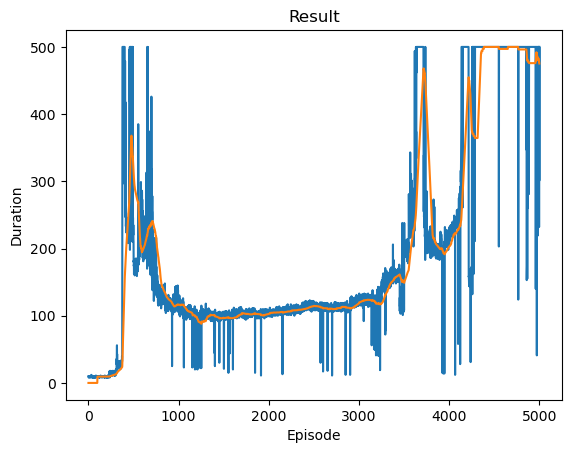

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
for i_episode in range(5000):
    s1 = torch.tensor(env.reset()[0],device=device,dtype = torch.float32).unsqueeze(0) #전처리는 없음
    state = s1
    for t in count(): #count(),
        action = select_action(state)
        observation,reward,terminated,truncated,_ = env.step(action.item())
        
        reward = torch.tensor(reward,device=device,dtype=torch.float32).view(1)
        done = terminated or truncated
        #terminal state에 도달하거나 timelimit따위로 episoder가 끝날때 done = True
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation,dtype=torch.float32,device=device).unsqueeze(0)
        
        #메모리에 변이 저장
        #print(next_state)
        """
        next_state = None,reward = 1 if terminated == True
        next_state = arbitary,reward = 1 o.w
        """
        memory.push(state,action,next_state,reward)
        
        optimize_model()
        #다음 상태로 이동
        state = next_state
        
        
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    if i_episode % 50 == 0:
        target_net.load_state_dict(policy_net.state_dict())
    

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

# Lambda function

In [320]:
def is_not_none(s):
    return s is not None
is_not_none(None)

False

# map function(function,iterable)

In [298]:
d = map(lambda s : s + 1,[1,2,3,4])
for i in d:
    print(i)

2
3
4
5


# zip

In [232]:
list(zip(*[[1,2,3,4],["a","b","c","d"],[True,False,False,True]]))

[(1, 'a', True), (2, 'b', False), (3, 'c', False), (4, 'd', True)]